Extrapolate measured fast-neutron spectrum from `reading_n_spectra.ipynb` to lower energies, append to thermal spectrum

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.constants as co
import scipy.stats as ss
import itertools
import pickle

from numpy import sqrt, exp, pi, log

In [2]:
mpl.rcParams['figure.facecolor'] = 'white'

In [3]:
# constants

# time for fast neutron to scatter enough times to fall to thermal energies
t_slow = 2.7e-6 # sec (2.7 us)

# time for thermal neutron to capture or decay (or otherwise be removed from consideration)
t_stop = 1e-4 # sec (100 us)

# approx room temperature
T = 298 # K (25 C)

# physical constants
k = co.physical_constants['Boltzmann constant in eV/K'][0] # Boltzmann constant in eV/K
B = 1/k/T # thermal energy constant [1/eV]
m_n = co.physical_constants['neutron mass energy equivalent in MeV'][0]*1e6 # neutron mass in eV
yr = 365*24*3600 # seconds per year
sealevel = 4/3600 # accepted neutron flux at sea level [cm^-2 s^-1]

In [4]:
# functions

def integrate_df(df):
    # (left-sided rectangular integral)
    dE = -df['E'].diff(periods = -1)
    dE.iat[-1] = dE.iat[-2]
    A = df['spec']*dE
    return A.sum()

def maxwell(E, B):
    # height of Maxwell distribution for energy E (eV) and temperature T (K) related to B via B = 1/kT
    return 2*B*sqrt(B*E/pi)*exp(-B*E)

In [5]:
# read in fast neutron flux spectrum (from reading_n_spectra.ipynb)
fast_flux_df = pd.read_pickle('data/FDF.txt') # 'E' in MeV, 'spec' in neutrons cm^-2 sec^-1 MeV^-1

# convert energy units to eV
fast_flux_df['E'] *= 1e6
fast_flux_df['spec'] /= 1e6

In [6]:
# calculate flux level of fast neutrons
fast_flux = integrate_df(fast_flux_df)

In [7]:
# extrapolate line from lower-energy fast neutrons
E_thresh = 2e4 # upper bound of linear region
E_therm = 0.15 # near boundary of where thermal distribution has peak

fast_lin_df = fast_flux_df.loc[fast_flux_df['E'] < E_thresh]

In [8]:
fitted_line = ss.linregress(log(fast_lin_df['E']), log(fast_lin_df['spec']))
print(fitted_line)

LinregressResult(slope=-0.5634745314989459, intercept=-19.828969504316163, rvalue=-0.9994012301448894, pvalue=1.6844740964661928e-08, stderr=0.008724275081512908, intercept_stderr=0.08368700493835901)


In [9]:
def fast_extrapolation_line(E):
    # return height of fitted loglog line, if energy is larger than thermal threshold
    return exp(fitted_line.intercept + fitted_line.slope*log(E))*(E > E_therm)

Text(0.4, 0.75, '$f = (2.446e-09) E^{ -0.563}$')

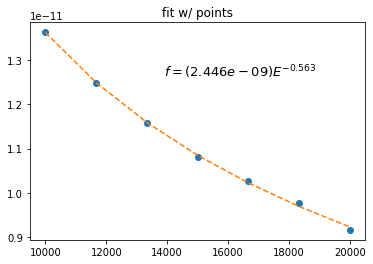

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('fit w/ points')
ax.plot(fast_lin_df['E'], fast_lin_df['spec'], 'o')
ax.plot(fast_lin_df['E'], fast_extrapolation_line(fast_lin_df['E']), linestyle = 'dashed')
ax.text(0.4, 0.75, f'$f = ({exp(fitted_line.intercept):.3e})'+' E^{' + f' {fitted_line.slope:.3f}'+'}$', transform = ax.transAxes, fontsize = 13)

Text(0, 0.5, 'flux [n cm^-2 s^-1 eV^-1]')

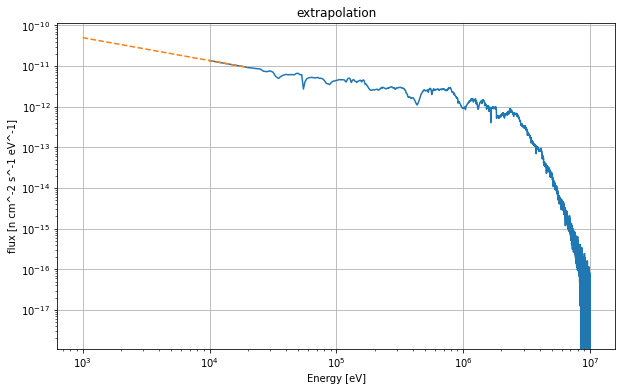

In [11]:
EE = np.geomspace(1000, 2e4, 10_000)

plt.figure(figsize = (10, 6))
plt.loglog()
plt.grid()
plt.plot(fast_flux_df['E'], fast_flux_df['spec'])
plt.plot(EE, fast_extrapolation_line(EE), linestyle = 'dashed')
plt.title('extrapolation')
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n cm^-2 s^-1 eV^-1]')

In [12]:
thermal_flux = fast_flux * t_stop/t_slow

print(f'fast neutron flux    = {fast_flux:.5e} n cm^-2 s^-1')
print(f'thermal neutron flux = {thermal_flux:.5e} n cm^-2 s^-1')
print(f'sea level flux       = {sealevel:.5e} n cm^-2 s^-1')

fast neutron flux    = 4.62963e-06 n cm^-2 s^-1
thermal neutron flux = 1.71468e-04 n cm^-2 s^-1
sea level flux       = 1.11111e-03 n cm^-2 s^-1


In [13]:
Es = np.geomspace(0.0001, 1e4, 2000)
Max = maxwell(Es, B)
Therms = thermal_flux*Max + fast_extrapolation_line(Es)
Therms2 = sealevel*Max #+ fast_extrapolation_line(Es)
Therms3 = sealevel*Max/1000 #+ fast_extrapolation_line(Es)

Text(0, 0.5, 'flux [n cm^-2 s^-1 eV^-1]')

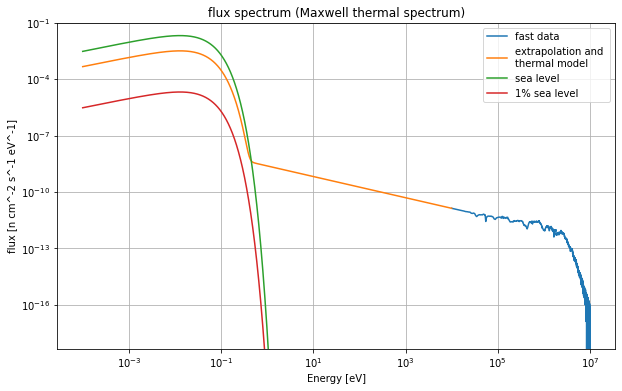

In [14]:
plt.figure(figsize = (10, 6))
plt.loglog()
plt.grid()
plt.plot(fast_flux_df['E'], fast_flux_df['spec'], label = 'fast data')
plt.plot(Es, Therms, label = 'extrapolation and \nthermal model')
axlim = plt.axis()
plt.plot(Es, Therms2, label = 'sea level')
plt.plot(Es, Therms3, label = '1% sea level')
plt.axis(list(axlim[:-1]) + [0.1])
plt.legend()
plt.title('flux spectrum (Maxwell thermal spectrum)')
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n cm^-2 s^-1 eV^-1]')

Text(0, 0.5, 'flux [n cm^-2 s^-1 eV^-1]')

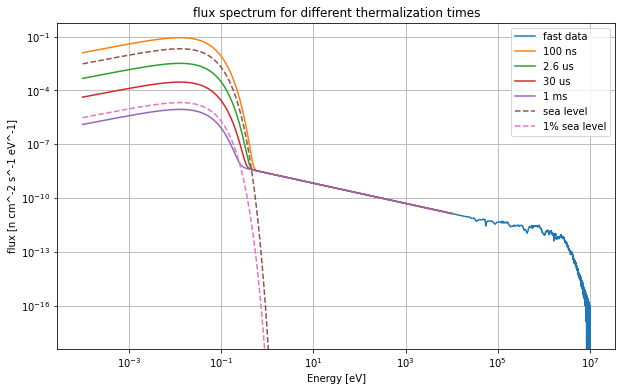

In [15]:
plt.figure(figsize = (10, 6))
plt.loglog()
plt.grid()
plt.plot(fast_flux_df['E'], fast_flux_df['spec'], label = 'fast data')


for thermaliz_time, thermaliz in zip([1e-7, 2.7e-6, 3e-5, 1e-3], ['100 ns', '2.6 us', '30 us', '1 ms']):
    plt.plot(Es, Max*fast_flux*t_stop/thermaliz_time + fast_extrapolation_line(Es), label = thermaliz)

axlim = plt.axis()

plt.plot(Es, Therms2, label = 'sea level', ls = 'dashed')
plt.plot(Es, Therms3, label = '1% sea level', ls = 'dashed')
plt.axis(axlim)
plt.legend()
plt.title('flux spectrum for different thermalization times')
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n cm^-2 s^-1 eV^-1]')

In [16]:
# print bounds of line
df_low_E = min(fast_flux_df["E"])

print(f'line between {E_therm} eV and {df_low_E/1000} keV')

line between 0.15 eV and 10.0 keV


In [17]:
spec_Es = np.concatenate((Es[:-1], fast_flux_df["E"].values))
spec_Fs = np.concatenate((Therms[:-1], fast_flux_df["spec"].values))

spec_stimate = pd.DataFrame.from_dict({'E': spec_Es, 'spec': spec_Fs})

Text(0, 0.5, 'flux [n cm^-2 s^-1 eV^-1]')

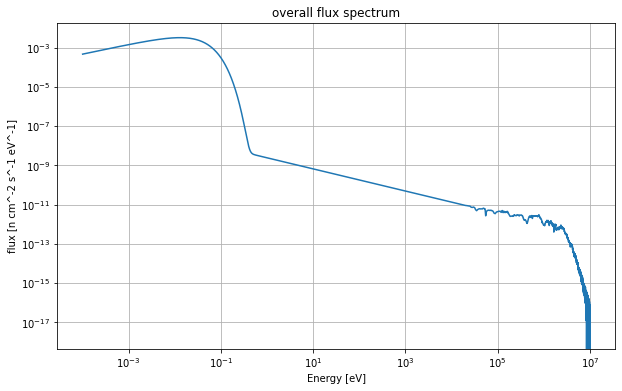

In [18]:
plt.figure(figsize = (10, 6))
plt.loglog()
plt.grid()

plt.plot(spec_stimate['E'], spec_stimate['spec'])

plt.title('overall flux spectrum')
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n cm^-2 s^-1 eV^-1]')

In [19]:
save_it = False
if save_it:
    spec_stimate.to_pickle('../data_files/neutron kinetic/placeholder_C.txt', protocol = pickle.HIGHEST_PROTOCOL)
    print('written')

In [20]:
# more constants
E_step = 0.025 # length of step-function distribution [eV]

In [21]:
def new_fast_extrapolation_line(E):
    # return height of fitted loglog line, if energy is larger than thermal threshold
    return exp(fitted_line.intercept + fitted_line.slope*log(E))

E_corner = new_fast_extrapolation_line(E_step)

def tophat(flux, connect_to_line = 0):
    height = flux/E_step # height of tophat
    return np.array([0, E_step, E_step]), np.array([height, height, connect_to_line*E_corner])

In [22]:
Es_line = np.geomspace(E_step, E_thresh, 100)
therm_line = new_fast_extrapolation_line(Es_line)

Text(0, 0.5, 'flux [n cm^-2 s^-1 eV^-1]')

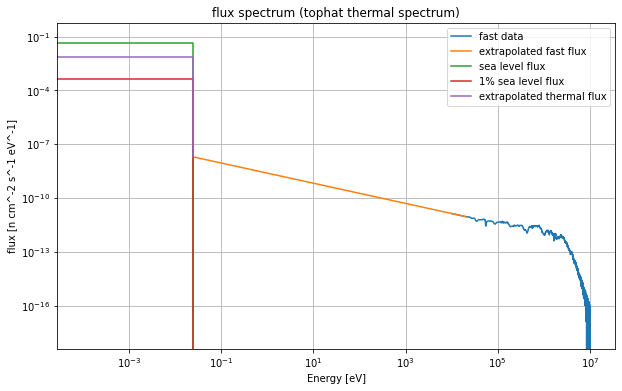

In [23]:
plt.figure(figsize = (10, 6))
plt.loglog()
plt.grid()
plt.axis(axlim)
plt.plot(fast_flux_df['E'], fast_flux_df['spec'], label = 'fast data')
plt.plot(Es_line, therm_line, label = 'extrapolated fast flux')
plt.plot(*tophat(sealevel), label = 'sea level flux')
plt.plot(*tophat(sealevel/100), label = '1% sea level flux')
plt.plot(*tophat(thermal_flux, True), label = 'extrapolated thermal flux')
plt.legend()
plt.title('flux spectrum (tophat thermal spectrum)')
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n cm^-2 s^-1 eV^-1]')